# Code Concepts User Study

### Setup

In [1]:
#!pip install bertviz
#!pip uninstall bertviz

In [2]:
#!pip install python-igraph
#!pip uninstall python-igraph

In [3]:
#!pip install plotly
#!pip uninstall plotly

In [4]:
!pip install ipympl
!pip install networkx
!pip install mplcursors

### Imports

In [5]:
#ENCAPSULED
import matplotlib.pyplot as plt
import networkx as nx
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
from statistics import mean
from CodeSyntaxConcept.tokenizer import CodeTokenizer
from CodeSyntaxConcept.parser import TreeSitterParser
import CodeSyntaxConcept.utils as utils
import mplcursors
import random

2023-02-26 09:30:41.740402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 09:30:43.597215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-02-26 09:30:43.597347: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-02-26 09:30:43.597356: W tensorflow/compiler/tf2tensorrt/utils/py_utils

### Parameters

In [ ]:
# specify a checkpoint to use, Transformer based text generation model (GPT)
# https://huggingface.co/models?other=text%20generation 
checkpoint = 'EleutherAI/gpt-neo-1.3B'
#checkpoint = 'EleutherAI/gpt-neo-125M'

In [ ]:
# specify a source code snippet sample
prompt = 'def multiply_numbers(number1, number2):\n     return'

prompt = 'def celsius_to_fahrenheit(celsius: float):\n    \"\"\"Converts the given temperature to fahrenheit and returns the result\"\"\"\n    fahrenheit = celsius * 1.8 + 32\n    return fahrenheit'

prompt = 'def celsius_to_fahrenheit(celsius: float):\n    """Converts the given temperature to fahrenheit and returns the result"""\n    fahrenheit = celsius.float()*float(celsius)\n    f'
# specify a source code snippet sample
#prompt = 'def bubblesort(elements):\n    swapped = False\n    # Looping from size of array from last index[-1] to index [0]\n    for n in range(len(elements)-1, 0, -1):\n        for i in range(n):\n            if elements[i] > elements[i + 1]:\n                swapped = True\n                # swapping data if the element is less than next element in the array\n                elements[i], elements[i + 1] = elements[i + 1], elements[i]       \n        if not swapped:\n            # exiting the function if we didn\'t make a single swap\n            # meaning that the array is already sorted.\n            return'

#prompt = 'def merge(*args, missing_val = None):\n#missing_val will be used when one of the smaller lists is shorter tham the others.\n#Get the maximum length within the smaller lists.\n  max_length = max([len(lst) for lst in args])\n  outList = []\n  for i in range(max_length):\n    result.append([args[k][i] if i < len(args[k]) else missing_val for k in range(len(args))])\n  return outList'
#prompt = '# A function to do inorder tree traversal\ndef printInorder(root):\n    if root:\n        # First recur on left child\n        printInorder(root.left)\n        # then print the data of node\n        print(root.val),\n        # now recur on right child\n        printInorder(root.right)'

#prompt = 'def bubbleSort(arr):\n    n = len(arr)\n    # optimize code, so if the array is already sorted, it doesn\'t need\n    # to go through the entire process\n    swapped = False\n    # Traverse through all array elements\n    for i in range(n-1):\n        # range(n) also work but outer loop will\n        # repeat one time more than needed.\n        # Last i elements are already in place\n        for j in range(0, n-i-1):\n            # traverse the array from 0 to n-i-1\n            # Swap if the element found is greater\n            # than the next element\n            if arr[j] > arr[j + 1]:\n                swapped = True\n                arr[j], arr[j + 1] = arr[j + 1], arr[j]      \n        if not swapped:\n            # if we haven\'t needed to make a single swap, we\n            # can just exit the main loop.\n            return'
#prompt = 'my_dict = {\n  \"brand\": \"Ford\",\n  \"model\": \"Mustang\",\n  \"year\": 1964\n}\n#Invert the dictionary based on its content\n#1- If we know all values are unique.\nmy_inverted_dict = dict(map(reversed, my_dict.items()))\n#2- If non-unique values exist\nfrom collections import defaultdict\nmy_inverted_dict = defaultdict(list)\n{my_inverted_dict[v].append(k) for k, v in my_dict.items()}\n#3- If any of the values are not hashable\nmy_dict = {value: key for key in my_inverted_dict for value in my_inverted_dict[key]}'
#prompt = 'mylist = [\'blue\', \'orange\', \'green\']\n#Map the list into a dict using the map, zip and dict functions\nmapped_dict = dict(zip(itr, map(fn, itr)))'
#prompt = 'print(\"Enter the Number: \")\nnum = int(input())\np = 0\nfor i in range(2, num):\n    if num%i==0:\n        p = 1\n        break\nif p==0:\n    print("\nIt is a Prime Number\")\nelse:\n    print("\nIt is not a Prime Number\")'
#prompt = 'print(\"Enter the Number: \")\nnum = int(input())\n\nrev = 0\ntemp = num\nwhile temp>0:\n    rem = temp%10\n    rev = rem + (rev*10)\n    temp = int(temp/10)\nif rev==num:\n    print(\"\nIt is a Palindrome Number\")\nelse:    print(\"\nIt is not a Palindrome Number\")'
#prompt = '# Returns index of x in arr if present, else -1\ndef binary_search(arr, low, high, x):\n    # Check base case\n    if high >= low:\n        mid = (high + low) // 2\n        # If element is present at the middle itself\n        if arr[mid] == x:\n            return mid \n        # If element is smaller than mid, then it can only\n        # be present in left subarray\n        elif arr[mid] > x:\n            return binary_search(arr, low, mid - 1, x) \n        # Else the element can only be present in right subarray\n        else:\n            return binary_search(arr, mid + 1, high, x)\n    else:\n        # Element is not present in the array\n        return -1'
#prompt = '# A Naive recursive Python implementation of LCS problem\ndef lcs(X, Y, m, n):\n    if m == 0 or n == 0:\n       return 0;\n    elif X[m-1] == Y[n-1]:\n       return 1 + lcs(X, Y, m-1, n-1);\n    else:\n       return max(lcs(X, Y, m, n-1), lcs(X, Y, m-1, n));'

#prompt = 'from collections import defaultdict\n#merge two or more dicts using the collections module\ndef merge_dicts(*dicts):\n  mdict = defaultdict(list)\n  for d in dicts:\n    for key in d:\n      mdict[key].append(d[key])\n  return dict(mdict)'

#prompt = '# Function to do insertion sort\ndef insertionSort(arr):   \n    if (n := len(arr)) <= 1:\n      return\n    for i in range(1, n):        \n        key = arr[i]\n        # Move elements of arr[0..i-1], that are\n        # greater than key, to one position ahead\n        # of their current position\n        j = i-1\n        while j >=0 and key < arr[j] :\n                arr[j+1] = arr[j]\n                j -= 1\n        arr[j+1] = key'

#prompt = '# Recursive Python function to solve tower of hanoi\ndef TowerOfHanoi(n, from_rod, to_rod, aux_rod):\n    if n == 0:\n        return\n    TowerOfHanoi(n-1, from_rod, aux_rod, to_rod)\n    print("Move disk", n, "from rod", from_rod, "to rod", to_rod)\n    TowerOfHanoi(n-1, aux_rod, to_rod, from_rod)'

In [ ]:
prompt = 'def countCharts(string, character):\n    """Naive count charts"""\n    count = 0\n    for letter in string:\n        if letter =\'\':\n           count += 1\n    print("Count {}".format(count, count))\n'

In [9]:
# programming language of the snippet.
language = "python"

### Processing

In [10]:
# ENCAPSULTED
text_generator_pipe = pipeline(task='text-generation', model=checkpoint)
text_generator_model = AutoModelForCausalLM.from_pretrained(checkpoint)
text_generator_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [11]:
# ENCAPSULTED
#encode
encoded_input = text_generator_tokenizer.encode_plus(prompt, return_tensors='pt', return_offsets_mapping=True)
#generates the original sequence (forward)
encoded_output = text_generator_model(encoded_input['input_ids'])
#encoded_output = text_generator_model.generate(**encoded_input, pad_token_id=text_generator_tokenizer.eos_token_id, max_length=len(encoded_input['input_ids'][0])+10, output_scores=True, return_dict_in_generate=True)
sequence_index = 0 # just 1 snippet

In [12]:
# ENCAPSULATED
## Actual probability case
def get_actual_probs(encoded_output, encoded_input ,sequence_index, text_generator_tokenizer):
    output_probs = encoded_output['logits'][sequence_index].softmax(dim=0)
    vocabulary_indexes = list(text_generator_tokenizer.get_vocab().values())
    vocabulary_values = list(text_generator_tokenizer.get_vocab().keys())
    sequence = []
    for input_id_index, input_id in enumerate(encoded_input['input_ids'][sequence_index]): ## Eliminate first token
        input_id_location = vocabulary_indexes.index(encoded_input['input_ids'][sequence_index][input_id_index].item())
        input_id_pred_prob = output_probs[input_id_index][input_id_location]
        #sequence.append((input_id.item(), input_id_pred_prob.item()))
        sequence.append((vocabulary_values[input_id_location], input_id_pred_prob.item()))
    return sequence


In [13]:
# ENCAPSULATED 
## Binds tree with actual probabilities
def bind_bpe_tokens(
    node,              #Tree sitter ast tree
    encodings,          #Token encoding
    actual_probs,      #Actual probabilities
    lines              #Source code Snippet
): 
    """Traverses the tree and bind the leaves with the corresponding node"""
    tree_node = {}
    tree_node['type'] = node.type
    tree_node['children'] = []
    tree_node['bindings'] = []
    tree_node['prob'] = 0

    node_span = [utils.convert_to_offset(node.start_point, lines), utils.convert_to_offset(node.end_point, lines)]

    for encoding_index, token_span in enumerate(encodings):
        if (node_span[0] <= token_span[0] and token_span[0] < node_span[1]) \
        or (node_span[0] < token_span[1] and token_span[1] <= node_span[1]) \
        or (node_span[0] >= token_span[0] and token_span[1] >= node_span[1]) :
            tree_node['bindings'].append(actual_probs[encoding_index])
    
    for n in node.children:
        tree_node['children'].append(bind_bpe_tokens(n, encodings, actual_probs, lines))
    
    tree_node['prob'] = mean([prob for element, prob in tree_node['bindings']])

    return tree_node
        

In [14]:
# ENCAPSULATED
def create_graph_from_binded_tree(binded_tree):

    def build_graph(graph, binded_ast_node, parent_node_id, labels, attributes):
        node_id = len(graph)
        graph.add_node(node_id)
        attributes[node_id] = {'type': binded_ast_node['type'], 'degree': len(binded_ast_node['children']) + 1, 'prob': binded_ast_node['prob'], 'tokens': [element for element, prob in binded_ast_node['bindings']]}
        labels[node_id] = binded_ast_node['type']
        if parent_node_id is not None:
            graph.add_edge(parent_node_id, node_id)     
        for child in binded_ast_node['children']:
            build_graph(graph, child, node_id, labels, attributes)
    graph = nx.DiGraph()
    labels = {}
    attributes = {}
    build_graph(graph, binded_tree, None, labels, attributes)
    return graph, labels, attributes

In [15]:
# ENCAPSULATED
## Asociate BPE tokens with terminals
concepts_tokenizer = CodeTokenizer.from_pretrained(checkpoint, language)
actual_probs = get_actual_probs(encoded_output, encoded_input ,sequence_index, text_generator_tokenizer)
tree = concepts_tokenizer.parser.parse(bytes(prompt, "utf8"))
binded_tree = bind_bpe_tokens(tree.root_node, encoded_input['offset_mapping'][sequence_index].tolist(), actual_probs, prompt.split('\n'))

### Visualize

In [18]:
# ENCAPSULATED
def hierarchy_pos(G, root=None, width=2., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5):
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))
        else:
            root = random.choice(list(G.nodes))
    def _hierarchy_pos(G, root, width=2., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

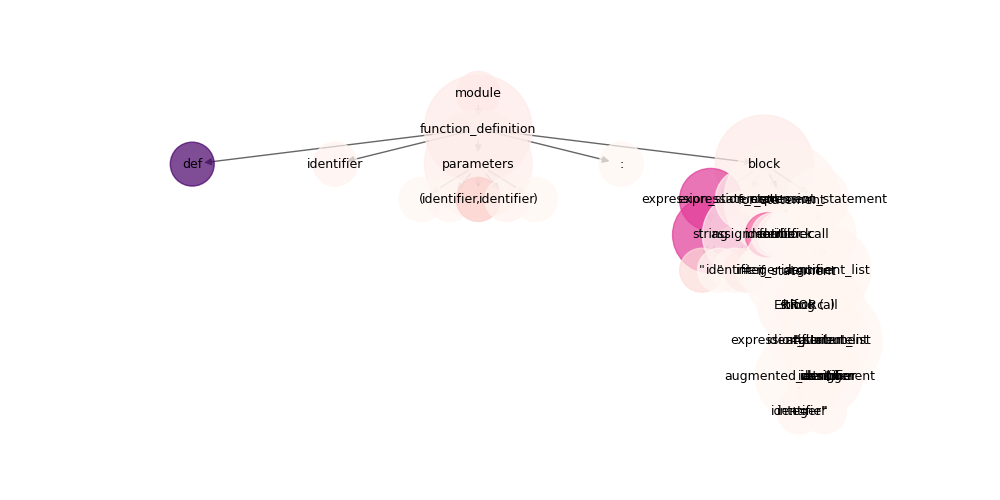

/home/svelascodimate/miniconda3/envs/code-syntax-concept/lib/python3.10/site-packages/mplcursors/_pick_info.py:142: UserWarning: Selection.target.index is deprecated and will be removed in the future; use Selection.index instead.
  warnings.warn(


In [19]:
%matplotlib widget

graph, labels, attributes = create_graph_from_binded_tree(binded_tree)
nx.set_node_attributes(graph, attributes)

#pos = nx.arf_layout(graph)
#pos = nx.circular_layout(graph)
pos = hierarchy_pos(graph, 0)
#pos = nx.planar_layout(graph)
#pos = nx.spectral_layout(graph)

node_color = [nx.get_node_attributes(graph, 'prob')[v] for v in graph]
node_size = [graph.degree(v)*1000 for v in graph]

nodes = nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=node_color, cmap = plt.cm.RdPu, alpha = 0.7)
nx.draw_networkx_labels(graph, pos, font_color='black', labels=labels, font_size=9)
nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), edge_color='.4', width=1)

def update_annot(sel):
    node_index = sel.target.index
    node_name = list(graph.nodes)[node_index]
    node_attr = graph.nodes[node_name]
    text = 'prob: ' + str(round(node_attr['prob'],4)) + '\n' \
        + 'tokens: ' + str(node_attr['tokens'])
    sel.annotation.set_text(text)

cursor = mplcursors.cursor(nodes)
cursor.connect('add', update_annot)


plt.rcParams["figure.figsize"] = (10,5)
plt.axis("off")
plt.show()